# Restricted Boltzmann Machine Defintion

In [1]:
# Import PyTorch library
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [2]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.zeros(n_hid, n_vis, device=device)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(1, n_vis, device=device)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid, device=device)  # fake dimension for the batch = 1
    
    def lr(self):
        return 0.02

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        w_extra = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        v_extra = torch.sum((v0 - vk), 0)
        h_extra = torch.sum((ph0 - phk), 0)

        # if self.i % 45 == 0:
            # print(torch.max(w_extra), torch.max(v_extra), torch.max(h_extra), flush=True)

        # Approximate the gradients with the CD algorithm
        # TODO learning rate toevoegen
        self.W += self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += self.lr() * v_extra
        self.h_bias += self.lr() * h_extra
        self.i += 1

In [3]:
cuda = torch.device('cuda')

# General Imports

In [4]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

In [5]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    # print(filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result)
    # break
    if filename_gzipped_python_json == steam_path + steam_reviews and 'user_id' not in parsed_result:
      continue
      
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df

In [6]:
steam_path = './data/'
metadata_games = 'steam_games.json.gz' 
user_items = 'australian_users_items.json.gz'
user_reviews = 'australian_user_reviews.json.gz'
game_bundles = 'bundle_data.json.gz'
steam_reviews= 'steam_reviews.json.gz'

# Australien Dataset

In [7]:

# for dataset in [metadata_games, user_items, user_reviews, game_bundles, steam_reviews]:
for dataset in [user_reviews]:
  print(f"----- {dataset}-----")
  size = os.path.getsize(steam_path + dataset) 
  print(f'Size of file is {size / 1000000}MB')
  df_metadata = parse_json(steam_path + dataset)
  pd.set_option('display.max_colwidth', None)
  # display(df_metadata.head(5))
#   display(df_metadata.describe(include='all'))

----- australian_user_reviews.json.gz-----
Size of file is 6.940139MB


25799it [00:01, 19659.45it/s]


Reading 25799 rows.


In [8]:
user_reviews_df = parse_json(steam_path + user_reviews)
user_reviews_df = user_reviews_df.drop_duplicates(subset='user_id')

25799it [00:01, 19347.97it/s]

Reading 25799 rows.


In [9]:
user_reviews_df_exploded = user_reviews_df.explode('reviews')
user_reviews_df_exploded = user_reviews_df_exploded.dropna()

In [10]:
def func(x):
    return x['recommend'], x["item_id"]

user_reviews_df_exploded['recommended'], user_reviews_df_exploded["item_id"] = zip(
    *user_reviews_df_exploded['reviews'].map(func)
)

In [11]:
user_reviews_df_exploded.reset_index()


user_reviews_df_exploded = user_reviews_df_exploded[['user_id', 'item_id', 'recommended']]

In [12]:
user_reviews_df_exploded["user_id"].value_counts()

76561198108415635      10
NanoPi                 10
banksyyo               10
snubbo                 10
BuffinMutton           10
                       ..
554076033               1
_maximus                1
maxstupo                1
maxy21                  1
SkullainnLovesGoats     1
Name: user_id, Length: 25457, dtype: int64

Filter users with 1 or no reviews

In [13]:
enkeltrue = user_reviews_df[['reviews']].apply(lambda x: [elem['recommend'] for elem in x['reviews']], axis=1)
enkeltrue.loc[enkeltrue.map(set).map(len) > 1]

24                         [False, True]
26       [True, True, True, False, True]
36                         [True, False]
60             [False, True, True, True]
71                         [False, True]
                      ...               
25758    [True, True, True, False, True]
25761                      [False, True]
25764                [True, True, False]
25768    [True, True, False, True, True]
25785                [True, True, False]
Length: 3684, dtype: object

In [14]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
user_reviews_df_exploded['item_id_int'] = user_reviews_df_exploded['item_id'].progress_apply(map_to_consecutive_id)
user_reviews_df_exploded.dtypes
f = open("item_dct.json", 'w')
json.dump(dct, f)
f.close()

100%|██████████| 58430/58430 [00:00<00:00, 1424794.38it/s]


Random train/test split

In [15]:
dct = {}
user_reviews_df_exploded['user_id_int'] = user_reviews_df_exploded['user_id'].progress_apply(map_to_consecutive_id)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(user_reviews_df_exploded, test_size=0.2)


test_df_grouped = test_df.groupby('user_id_int').agg(list)
test_df_grouped = test_df_grouped.reset_index()

train_df_grouped = train_df.groupby('user_id_int').agg(list)
train_df_grouped = train_df_grouped.reset_index()


100%|██████████| 58430/58430 [00:00<00:00, 1358559.04it/s]


In [16]:
train_df_grouped["item_id"].apply(len).describe()

count    22580.000000
mean         2.070151
std          1.668226
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: item_id, dtype: float64

Create Sparse Matrix

In [17]:
#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (user_reviews_df_exploded['user_id_int'].max() + 1, user_reviews_df_exploded['item_id_int'].max() + 1)
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id_int']
        user = row['user_id_int']
    
        recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([2 if recommended[i] else 1 for i in range(len(items))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [18]:
test_matrix = get_sparse_matrix(test_df_grouped)

train_matrix = get_sparse_matrix(train_df_grouped)
train_matrix


<25457x3682 sparse matrix of type '<class 'numpy.intc'>'
	with 46744 stored elements in Compressed Sparse Row format>

In [19]:
torch.manual_seed(0)

Train model

In [67]:
def score_model(rbm, batch_size):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            v, _ = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2)) * len(vt > -1)
            s += len(vt > -1) 

    return test_recon_error / s


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

def create_rbm(n_vis, n_hidden, batch_size, epochs, rbm=None) -> RBM:
    train_errors = []
    test_errors = []
    if rbm is None:
        rbm = RBM(n_vis, n_hidden)

    print("start training")
    for epoch in tqdm(range(epochs)):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            training_sample2 = train_matrix[user_id : user_id + batch_size]
            # print(training_sample)
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
            # print(v0.coalesce().indices())
            vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

            v0 = v0.to_dense()
            vk = vk.to_dense()
            v0 = v0.sub(1)
            vk = vk.sub(1)
            
            ph0, _ = rbm.sample_h(v0)

            hk = None

            # Third for loop - perform contrastive divergence
            # TODO misschien is iets lager proberen?
            for k in range(1):
                _, hk = rbm.sample_h(vk)
                _, vk = rbm.sample_v(hk)

                # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
                # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
                vk[v0 < 0] = v0[v0 < 0]
                

            phk, _ = rbm.sample_h(vk)

            rbm.train_model(v0, vk, ph0, phk)
            vk, _ = rbm.sample_v(hk)
            
            train_recon_error += torch.sqrt(torch.mean((v0[v0 > -1] - vk[v0 > -1])**2)) * len(v0 > -1)
            s += len(v0 > -1)
            
            # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
            # print(torch.sum((-vk + v0), 0).shape)
            # print(torch.sum((ph0 - phk), 0).shape)
            
        train_errors.append(train_recon_error / s)

        # print('calculating test scores')
        rbm.eval()
        test_errors.append(score_model(rbm, batch_size))

        # print('finished epoch', epoch)    

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'aussies-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


Hitrate / Recall

In [97]:
def compute_hr(rbm, k=10, batch_size=100):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    idcg = np.sum([1 / np.log2(i+2) for i in range(k)])
    # for loop - go through every single user
    for id_user in range(0, user_reviews_df_exploded['user_id_int'].max() + 1): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data == 2]
        # print(target_test)

        v = v.todense()

        v = v - 1
        v = torch.Tensor(v)
        if torch.cuda.is_available():
            v = v.cuda()
        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            _, h = rbm.sample_h(v)
            recommended, _ = rbm.sample_v(h)

            # all recommendations
            _, indices =  torch.topk(recommended[v < 0], k)
            recommendations = torch.tensor(indices, device='cpu').tolist()

            counter = 0
            total = len(target_recommendations)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            counter = 0
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG


start training


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


start training


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


10 epochs
hr 0.17008906481939634
recall 0.14490454395513772
20 epochs
hr 0.05467590301830777
recall 0.04533028203859475


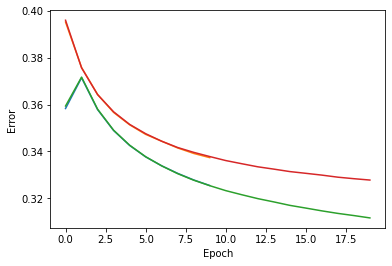

In [29]:
rbm10 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 10)
rbm20 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 20)

In [98]:
print("10 epochs")
hr, r, ndcg = compute_hr(rbm10)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

print("20 epochs")
hr, r, ndcg = compute_hr(rbm20)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))


10 epochs


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/2552676182.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.17008906481939634
recall 0.14490454395513772
ndcg 0.019980044960139953
20 epochs
hr 0.05467590301830777
recall 0.04533028203859475
ndcg 0.006054178048878387


In [81]:
def recommend(rbm, v, vt, k, p=True):
    target_data = vt.data
    target_index = vt.indices
    target_recommendations = target_index[target_data == 2]
    v = v.todense()
    v = v - 1
    v = torch.Tensor(v)
    if torch.cuda.is_available():
        v = v.cuda()
    
    _, h = rbm.sample_h(v)
    recommended, _ = rbm.sample_v(h)

    # all recommendations
    values, indices =  torch.topk(recommended[v < 0], k)
    recommendations = torch.tensor(indices, device='cpu').tolist()

    if p:
        print('20', recommended[0][20])
        print('21', recommended[0][21])
        print("average value", torch.mean(recommended[0]))

    found = True
    for r in recommendations:
        if r in target_recommendations:
            if p:
                print("HIT")
            found = True
            break

    if found and p:
        print("values", values)
        print("recommended", recommendations)
        print("real", target_recommendations)

    
    
    return recommendations

user = 4
# print("train", train_matrix[user])
# print("test", test_matrix[user])

print("EPOCHS 10")
recommend(rbm10, train_matrix[user], test_matrix[user], 10)
print('---' * 10)
print("EPOCHS 20")
recommend(rbm20, train_matrix[user], test_matrix[user], 10)

EPOCHS 10
20 tensor(0.9002, device='cuda:0')
21 tensor(0.8984, device='cuda:0')
average value tensor(0.5607, device='cuda:0')
HIT
values tensor([0.9785, 0.9785, 0.9777, 0.9763, 0.9734, 0.9718, 0.9701, 0.9658, 0.9569,
        0.9561], device='cuda:0')
recommended [62, 25, 34, 28, 60, 198, 0, 21, 54, 139]
real [20 21]
------------------------------
EPOCHS 20
20 tensor(0.9137, device='cuda:0')
21 tensor(0.9321, device='cuda:0')
average value tensor(0.5876, device='cuda:0')
values tensor([0.9871, 0.9852, 0.9846, 0.9805, 0.9802, 0.9772, 0.9763, 0.9763, 0.9754,
        0.9749], device='cuda:0')
recommended [62, 34, 0, 54, 198, 139, 60, 93, 331, 308]
real [20 21]


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


[62, 34, 0, 54, 198, 139, 60, 93, 331, 308]

start training


0it [00:00, ?it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 7/7 [00:05<00:00,  1.23it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


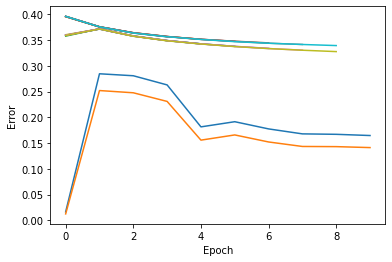

In [63]:
hrs = []
rs = []
for i in range(10):
    rbm = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, i)
    hr, r = compute_hr(rbm)
    hrs.append(np.average(hr))
    rs.append(np.average(r))



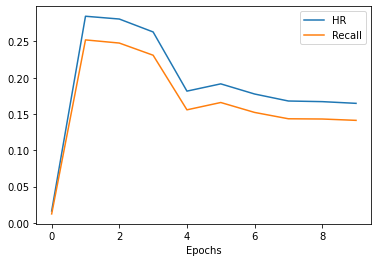

In [66]:
plt.clf()
plt.plot(hrs, label='HR')
plt.plot(rs, label='Recall')
plt.xlabel("Epochs")
plt.legend()

start training


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.043295398317664525
recall 0.034960003298697015


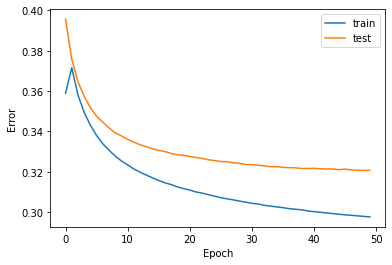

In [68]:
rbm50 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 50)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

In [69]:
print("EPOCHS 50")
recommend(rbm50, train_matrix[user], test_matrix[user], 10)

EPOCHS 50
20 tensor(0.9153, device='cuda:0')
21 tensor(0.9358, device='cuda:0')
tensor(0.6323, device='cuda:0')
values tensor([0.9930, 0.9917, 0.9917, 0.9910, 0.9908, 0.9906, 0.9888, 0.9876, 0.9863,
        0.9855], device='cuda:0')
recommended [0, 139, 36, 331, 93, 62, 54, 110, 34, 195]
real [20 21]


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/3369171806.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


True

In [85]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm50, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


95


In [87]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm20, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


88


In [89]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm10, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


77


In [86]:
print(train_matrix.shape[1])

3682


start training


100%|██████████| 500/500 [07:14<00:00,  1.15it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.043295398317664525
recall 0.034960003298697015


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


113


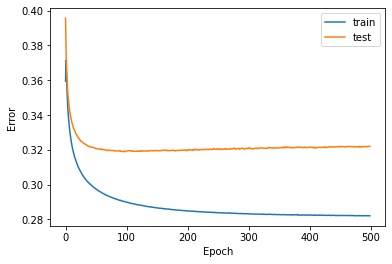

In [90]:
rbm500 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 500)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm500, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

In [91]:
hr, r = compute_hr(rbm500)
print("hr", np.average(hr))
print("recall", np.average(r))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.02016328550222662
recall 0.015879102754412004


start training


100%|██████████| 2000/2000 [29:41<00:00,  1.12it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.01991588322612568
recall 0.015823437242289295


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


20 tensor(0.8829, device='cuda:0')
21 tensor(0.9334, device='cuda:0')
average value tensor(0.7591, device='cuda:0')
values tensor([0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9995,
        0.9995], device='cuda:0')
recommended [139, 36, 331, 110, 93, 248, 195, 539, 379, 336]
real []
107


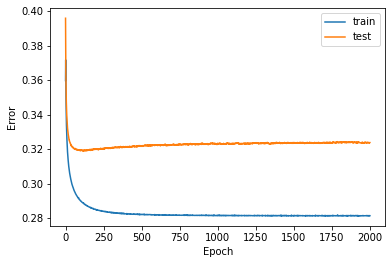

In [92]:
rbm2000 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 2000)
hr, r = compute_hr(rbm2000)
print("hr", np.average(hr))
print("recall", np.average(r))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm2000, train_matrix[u], test_matrix[u], 10, u == train_matrix.shape[0] - 1)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

In [ ]:
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('errors.jpg')

In [ ]:
# torch.save(rbm.state_dict(), "./network")

In [ ]:
rbm = RBM(n_vis, n_hidden)
rbm.load_state_dict(torch.load("./network"))
rbm.eval()

# Reading Full Dataset

In [54]:
steam_reviews_df = parse_json(steam_path + steam_reviews)
steam_reviews_df_small = steam_reviews_df[['user_id', 'product_id', 'recommended', 'date']]

7793069it [03:52, 33544.36it/s]


Reading 3176223 rows.


In [55]:
steam_reviews_df_cleaned = steam_reviews_df_small.dropna(axis=0, subset=['user_id'])

In [56]:
steam_reviews_df_cleaned.head(5)
steam_reviews_df["user_id"].value_counts(dropna=False)

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198345086561       1
76561198054491833       1
76561198095690287       1
76561198301658414       1
76561198089897928       1
Name: user_id, Length: 1485611, dtype: int64

In [57]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
steam_reviews_df_cleaned['product_id_int'] = steam_reviews_df_cleaned['product_id'].progress_apply(map_to_consecutive_id)

100%|██████████| 3176223/3176223 [00:01<00:00, 1672200.46it/s]


## Random Split

In [58]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(steam_reviews_df_cleaned, test_size=0.2)


# test_df_grouped = test_df.groupby('user_id_int').agg(list)
# test_df_grouped = test_df_grouped.reset_index()

# train_df_grouped = train_df.groupby('user_id_int').agg(list)
# train_df_grouped = train_df_grouped.reset_index()

## Date Split

In [59]:
steam_reviews_df_cleaned["date"] = pd.to_datetime(steam_reviews_df_cleaned["date"])
display(steam_reviews_df_cleaned.dtypes)
display(steam_reviews_df_cleaned.head(5))


user_id                   object
product_id                object
recommended                 bool
date              datetime64[ns]
product_id_int             int64
dtype: object

,user_id,product_id,recommended,date,product_id_int
0,76561198007483075,35140,True,2018-01-04,0
1,76561197970402776,707610,True,2017-10-16,1
2,76561198060686749,328100,True,2017-06-23,2
3,76561198023491401,35140,True,2018-01-03,0
4,76561198115331805,35140,True,2018-01-03,0


In [60]:
steam_reviews_df_grouped = steam_reviews_df_cleaned.groupby("user_id")[["product_id_int", "recommended", "date"]].agg(list)
display(steam_reviews_df_grouped.head(5))

steam_reviews_df_grouped_smaller = steam_reviews_df_grouped[steam_reviews_df_grouped["recommended"].map(len) > 1]
display(steam_reviews_df_grouped_smaller.head(5))


,product_id_int,recommended,date
user_id,,,
76561197960265806,[14313],[True],[2017-12-20 00:00:00]
76561197960266010,[9722],[True],[2017-11-27 00:00:00]
76561197960266146,[597],[True],[2017-11-04 00:00:00]
76561197960266225,[1622],[True],[2017-06-07 00:00:00]
76561197960266375,[3716],[True],[2017-09-13 00:00:00]


,product_id_int,recommended,date
user_id,,,
76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]"
76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]"
76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]"
76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]"
76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]"


In [61]:
dct.clear()
steam_reviews_df_grouped_smaller = steam_reviews_df_grouped_smaller.reset_index()
steam_reviews_df_grouped_smaller["user_id_int"] = steam_reviews_df_grouped_smaller["user_id"].progress_apply(map_to_consecutive_id)

100%|██████████| 581343/581343 [00:00<00:00, 1167091.91it/s]


In [62]:
display(steam_reviews_df_grouped_smaller.shape)
display(steam_reviews_df_grouped.shape)
print(steam_reviews_df_grouped.shape[0] - steam_reviews_df_grouped_smaller.shape[0])

(581343, 5)

(1485611, 3)

904268


In [63]:

def split(items, train_percentage):
    train_count = math.floor(len(items) * train_percentage)
    return items[0:train_count], items[train_count:]

train_percentage = 0.8
steam_reviews_df_grouped_smaller["product_history"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["product_future"] = steam_reviews_df_grouped_smaller["product_id_int"].progress_apply(lambda items: split(items, train_percentage)[1])
steam_reviews_df_grouped_smaller["recommended_history"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[0])
steam_reviews_df_grouped_smaller["recommended_future"] = steam_reviews_df_grouped_smaller["recommended"].progress_apply(lambda items: split(items, train_percentage)[1])
display(steam_reviews_df_grouped_smaller.head(5))

100%|██████████| 581343/581343 [00:00<00:00, 1149768.63it/s]


,user_id,product_id_int,recommended,date,user_id_int,product_history,product_future,recommended_history,recommended_future
0,76561197960266546,"[2678, 2678]","[True, True]","[2016-11-25 00:00:00, 2016-11-25 00:00:00]",0,[2678],[2678],[True],[True]
1,76561197960266564,"[7259, 7259]","[True, True]","[2016-08-14 00:00:00, 2016-08-14 00:00:00]",1,[7259],[7259],[True],[True]
2,76561197960267022,"[7779, 13382]","[True, True]","[2015-09-29 00:00:00, 2015-04-16 00:00:00]",2,[7779],[13382],[True],[True]
3,76561197960267615,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736, 12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[2012-11-06 00:00:00, 2011-11-30 00:00:00, 2011-07-16 00:00:00, 2011-11-30 00:00:00, 2012-04-04 00:00:00, 2011-07-06 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2013-01-09 00:00:00, 2011-11-30 00:00:00, 2013-10-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-09-13 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-11-05 00:00:00, 2011-11-30 00:00:00, 2011-07-20 00:00:00, 2012-12-14 00:00:00, 2011-11-30 00:00:00, 2011-11-30 00:00:00, 2010-12-10 00:00:00, 2011-11-30 00:00:00, 2012-07-14 00:00:00, 2011-07-30 00:00:00, 2011-11-30 00:00:00]",3,"[1428, 2098, 2545, 2643, 2633, 3052, 3150, 3979, 3979, 5255, 5797, 5747, 5884, 6832, 6500, 6956, 7122, 7102, 7352, 7469, 7931, 9757, 9911, 10291, 11006, 11309, 11432, 11736]","[12754, 12703, 12755, 13323, 13215, 13544, 14085, 14055]","[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, True]"
4,76561197960268226,"[9485, 13462]","[True, True]","[2015-06-01 00:00:00, 2016-11-28 00:00:00]",4,[9485],[13462],[True],[True]


In [64]:
steam_reviews_df_grouped_smaller["recommended"].map(len).describe()
steam_reviews_df_grouped_smaller["recommended"].map(len).sum()

2271955

In [65]:
#Create scipy csr matrix
def get_sparse_matrix(df, shape, recommended_col="recommended_history", product_col="product_history"):
    user_ids = []
    product_ids = []
    values = []
    for _, row in df.iterrows():
        products = row[product_col]
        user = row['user_id_int']
    
        recommended = row[recommended_col]
        user_ids.extend([user] * len(products))
        product_ids.extend(products)
        values.extend([2 if recommended[i] else 1 for i in range(len(products))])
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, product_ids)), shape=shape, dtype=np.int32)
    return matrix

In [66]:
steam_reviews_set = steam_reviews_df_grouped_smaller#.head(100000)

In [67]:
shape = (steam_reviews_set.shape[0], steam_reviews_df_cleaned['product_id_int'].max() + 1)

steam_reviews_set = steam_reviews_set.reset_index()
train_matrix = get_sparse_matrix(steam_reviews_set, shape)
test_matrix = get_sparse_matrix(steam_reviews_set, shape, recommended_col="recommended_future", product_col="product_future")
train_matrix

<581343x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 1404885 stored elements in Compressed Sparse Row format>

In [68]:
test_matrix

<581343x14513 sparse matrix of type '<class 'numpy.intc'>'
	with 708285 stored elements in Compressed Sparse Row format>

# Model RBM

-------
start training


100%|██████████| 10/10 [24:20<00:00, 146.01s/it]


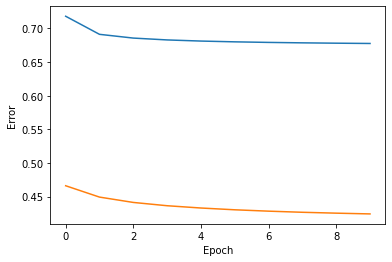

In [75]:
def score_model(rbm, batch_size):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, user_reviews_df_exploded['user_id_int'].max() + 1 - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        v = v - 1
        vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            v, _ = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2)) * len(vt > -1)
            s += len(vt > -1) 

    return test_recon_error / s

print('-------')
n_vis = shape[1]
n_hidden = 2000
batch_size = 2048 
epochs = 10
train_errors = []
test_errors = []
rbm = RBM(n_vis, n_hidden)

# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    if torch.cuda.is_available():
        i = i.cuda()
        v = v.cuda()
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

print("start training")
for epoch in tqdm(range(epochs)):
    rbm.train()
    train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0
    
    for user_id in range(0, shape[0] - batch_size, batch_size):
        training_sample = train_matrix[user_id : user_id + batch_size]
        training_sample2 = train_matrix[user_id : user_id + batch_size]
        # print(training_sample)
        v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # print(v0.coalesce().indices())
        vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

        v0 = v0.to_dense()
        vk = vk.to_dense()
        v0 = v0.sub(1)
        vk = vk.sub(1)
        
        ph0, _ = rbm.sample_h(v0)   

        # Third for loop - perform contrastive divergence
        for k in range(5):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)

            # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
            # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
            vk[v0 < 0] = v0[v0 < 0]

        phk, _ = rbm.sample_h(vk)
        rbm.train_model(v0, vk, ph0, phk)

        vk_train, _ = rbm.sample_v(hk)
        train_recon_error += torch.sqrt(torch.mean((v0[v0 > -1] - vk_train[v0 > -1])**2)) * len(v0 > -1)
        s += len(v0 > -1) 
        
    train_errors.append(train_recon_error / s)

    # print('calculating test scores')
    # rbm.eval()
    # test_errors.append(score_model(rbm)) 
    rbm.eval()
    test_errors.append(score_model(rbm, batch_size))

    # print('finished epoch', epoch)    
    
import matplotlib.pyplot as plt
# Plot the RMSE reconstruction error with respect to increasing number of epochs
plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig(f'datasubset-{n_hidden}-{batch_size}-{epochs}-test.jpg')

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)

Hitrate / Recall

In [70]:
hr, r = compute_hr(rbm)
print('hr', np.average(hr))
print("recall", np.average(r))

C:\Users\jolan\AppData\Local\Temp/ipykernel_6996/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.0006022403340426386
recall 0.0006022403340426386


In [71]:
display(train_errors)
display(test_errors)

[tensor(0.7204, device='cuda:0'),
 tensor(0.6915, device='cuda:0'),
 tensor(0.6858, device='cuda:0'),
 tensor(0.6830, device='cuda:0'),
 tensor(0.6813, device='cuda:0'),
 tensor(0.6801, device='cuda:0'),
 tensor(0.6792, device='cuda:0'),
 tensor(0.6786, device='cuda:0'),
 tensor(0.6781, device='cuda:0'),
 tensor(0.6777, device='cuda:0'),
 tensor(0.6773, device='cuda:0'),
 tensor(0.6770, device='cuda:0'),
 tensor(0.6768, device='cuda:0'),
 tensor(0.6765, device='cuda:0'),
 tensor(0.6764, device='cuda:0'),
 tensor(0.6762, device='cuda:0'),
 tensor(0.6760, device='cuda:0'),
 tensor(0.6759, device='cuda:0'),
 tensor(0.6758, device='cuda:0'),
 tensor(0.6757, device='cuda:0'),
 tensor(0.6756, device='cuda:0'),
 tensor(0.6755, device='cuda:0'),
 tensor(0.6754, device='cuda:0'),
 tensor(0.6753, device='cuda:0'),
 tensor(0.6753, device='cuda:0'),
 tensor(0.6752, device='cuda:0'),
 tensor(0.6751, device='cuda:0'),
 tensor(0.6751, device='cuda:0'),
 tensor(0.6750, device='cuda:0'),
 tensor(0.6750

[tensor(0.4664, device='cuda:0'),
 tensor(0.4493, device='cuda:0'),
 tensor(0.4414, device='cuda:0'),
 tensor(0.4365, device='cuda:0'),
 tensor(0.4331, device='cuda:0'),
 tensor(0.4305, device='cuda:0'),
 tensor(0.4285, device='cuda:0'),
 tensor(0.4268, device='cuda:0'),
 tensor(0.4255, device='cuda:0'),
 tensor(0.4243, device='cuda:0'),
 tensor(0.4234, device='cuda:0'),
 tensor(0.4225, device='cuda:0'),
 tensor(0.4218, device='cuda:0'),
 tensor(0.4211, device='cuda:0'),
 tensor(0.4205, device='cuda:0'),
 tensor(0.4200, device='cuda:0'),
 tensor(0.4195, device='cuda:0'),
 tensor(0.4190, device='cuda:0'),
 tensor(0.4186, device='cuda:0'),
 tensor(0.4182, device='cuda:0'),
 tensor(0.4179, device='cuda:0'),
 tensor(0.4176, device='cuda:0'),
 tensor(0.4173, device='cuda:0'),
 tensor(0.4170, device='cuda:0'),
 tensor(0.4168, device='cuda:0'),
 tensor(0.4165, device='cuda:0'),
 tensor(0.4163, device='cuda:0'),
 tensor(0.4161, device='cuda:0'),
 tensor(0.4159, device='cuda:0'),
 tensor(0.4157

In [72]:
s = steam_reviews_df_small["user_id"].value_counts(dropna=False)
display(s.loc[s < 2])
display(s.loc[s >= 2])
display(s)

76561198037833890    1
76561197992194309    1
76561198043292775    1
76561198030442121    1
76561197963870074    1
                    ..
76561198345086561    1
76561198054491833    1
76561198095690287    1
76561198301658414    1
76561198089897928    1
Name: user_id, Length: 904268, dtype: int64

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198098554655       2
76561198044342349       2
76561198122784122       2
76561198076341138       2
76561198102545130       2
Name: user_id, Length: 581343, dtype: int64

76561198011965365    1254
76561198094803808     900
76561197969749884     750
76561198094321628     669
76561198073092169     549
                     ... 
76561198345086561       1
76561198054491833       1
76561198095690287       1
76561198301658414       1
76561198089897928       1
Name: user_id, Length: 1485611, dtype: int64

In [73]:
test_errors

[tensor(0.4664, device='cuda:0'),
 tensor(0.4493, device='cuda:0'),
 tensor(0.4414, device='cuda:0'),
 tensor(0.4365, device='cuda:0'),
 tensor(0.4331, device='cuda:0'),
 tensor(0.4305, device='cuda:0'),
 tensor(0.4285, device='cuda:0'),
 tensor(0.4268, device='cuda:0'),
 tensor(0.4255, device='cuda:0'),
 tensor(0.4243, device='cuda:0'),
 tensor(0.4234, device='cuda:0'),
 tensor(0.4225, device='cuda:0'),
 tensor(0.4218, device='cuda:0'),
 tensor(0.4211, device='cuda:0'),
 tensor(0.4205, device='cuda:0'),
 tensor(0.4200, device='cuda:0'),
 tensor(0.4195, device='cuda:0'),
 tensor(0.4190, device='cuda:0'),
 tensor(0.4186, device='cuda:0'),
 tensor(0.4182, device='cuda:0'),
 tensor(0.4179, device='cuda:0'),
 tensor(0.4176, device='cuda:0'),
 tensor(0.4173, device='cuda:0'),
 tensor(0.4170, device='cuda:0'),
 tensor(0.4168, device='cuda:0'),
 tensor(0.4165, device='cuda:0'),
 tensor(0.4163, device='cuda:0'),
 tensor(0.4161, device='cuda:0'),
 tensor(0.4159, device='cuda:0'),
 tensor(0.4157